## Phase 4 (Modeling): k-Nearest Neighbor -- Neue Gütemaße

* Autorin: Anna (i3-Versicherung)
* Webseite: [Data Science Training - Kapitel 6](https://data-science.training/kapitel-6/)
* Datum: 23.03.2023

Neben der Genauigkeit (Accuracy) betrachten wir nun weitere Gütemaße.
Relevant sind in dieser Fallstudie neben der Genauigkeit (Accuracy) auch die Präzision (Precision),
das F-Maß (F-Score) und die Fläche unter der ROC-Kurve (AURC).

Das Diagramm zur Receiver Operating Characteristic (ROC) wird mittels Matplotlib bzw. Seaborn erstellt und gespeichert.

In [1]:
# Pandas Paket (Package) importieren
#  Datenstrukturen und Datenanalyse, I/O
#  https://pandas.pydata.org/pandas-docs/stable/
import pandas as pd
# NumPy Paket (Package) importieren
#  Mehrdimensionale Datenstrukturen (Vektoren, Matrizen, Tensoren, Arrays), Lineare Algebra
#  https://numpy.org/doc/
import numpy as np
# Klassen und Funktionen der scikit-learn Module importieren
#  Maschinelles Lernen, Algorithmen
#  https://scikit-learn.org/stable/modules/classes.html
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score 
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# Matplot Bibliothek (Modul) importieren
#  Mathematische grafische Daten-Visualisierungen
#  https://matplotlib.org/contents.html
import matplotlib.pyplot as plt
# Seaborn Bibliothek (Modul) importieren
#  High-end Daten-Visualisierungen auf Basis von Matplot
#  https://seaborn.pydata.org/
import seaborn as sns
# Deutsches Zahlenformat
import locale
locale.setlocale(locale.LC_ALL, 'de')
# Eigene Module importieren
#  zur Bewertung der Modelle
import sys
sys.path.append('../00_DST_Module/')
import dst_score_functions as sf
# Warnungen unterdrücken
#import warnings
#warnings.filterwarnings('ignore')

In [2]:
# Seaborn: Allgemeine Einstellungen

# Schriftart setzen
sns.set(font = 'Arial')
# Schriftgröße setzen
sns.set(font_scale = 2.5)
# Achsen im deutschen Zahlenformat
plt.rcParams['axes.formatter.use_locale'] = True
# Bildgröße setzen (16 x 9)
sns.set(rc={'figure.figsize':(8, 4.5)})
# Weißes Gitter setzen
sns.set_style('whitegrid')

In [3]:
# Ausgabe der Receiver Operation Characteristic (ROC)
# mit Hilfe des Models, der (Trainings-)Daten (X, y) und der Kreuzvalidierung (Cross Validation cv)
# in Phase 4 (Modeling) der Datenanalyse nach CRISP-DM
#
# Quelle: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html
#
def dst_roc_SAVE(model, X, y, cv):
    
    # Initialisierungen
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    fig, ax = plt.subplots()
    
    # Schleife über alle Validierungsmengen
    for train_index, test_index in cv.split(X, y):
        
        # Bilde die Trainings- und Validierungsmengen
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
        # Modell mit Trainigsdaten trainieren
        model.fit(X_train, y_train)
    
        # False Positive Rate (FPR) und True Positive Rate (TPR) aus Validierungsdaten berechnen
        y_prob = model.predict_proba(X_test)
        y_pred = y_prob[:,1]
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
    
        # ROC zeichnen (Dünne Kurven)
        ax.plot(fpr, tpr, color='blue', alpha=0.3, lw=1)
    
        # Linreare Interpolation
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))
        
    # Mittelwert (Dicke Kurve)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = 100 * auc(mean_fpr, mean_tpr)
    std_auc  = 100 * np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='blue', lw=2, alpha=0.8, label='ROC [AURC %0.2f $\pm$ %0.2f]' % (mean_auc, std_auc))
    
    # Korridor (Standardabweichungen)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + 2 * std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - 2 * std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=0.2, label='$\pm$ 2 STD')

    # Zufall (Diagonale)
    ax.plot([0, 1], [0, 1], linestyle="--", color='red', lw=2, alpha=0.8, label='Zufall')

    # Beschriftungen
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title='Receiver Operating Characteristic (ROC)', \
           xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)')
    ax.legend(loc='lower right')
    
    # Grafik speichern
    plt.savefig('../../figures/svg/ROC_kNN_Example.svg', format='svg', dpi=1200, transparent=True)

In [4]:
# Datenversion festlegen: 4, 5
version  = 5
# Modell-Abkürzung festlegen: knn = k Nearest Neighbor
shortcut = 'knn'

In [5]:
# Trainingsdaten als Pandas Data Frame (df) aus Excel-Dateien laden
#  (KNIME: "Excel Reader")
filename = '../../data/titanic/new/training_v' + str(version) + '.xlsx'
df_train = pd.read_excel(filename)

In [6]:
df_train.columns

Index(['Survived', 'KnownCabin', 'Child', 'FamilySize', 'LogFare', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare'],
      dtype='object')

In [7]:
# Beschreibende Attribute extrahieren
X = df_train.iloc[:,1:].values
# Klassenattribut (Survived) extrahieren
y = df_train.iloc[:,0].values

In [8]:
# Min-Max-Normierung für Version 5
# Daten auf das Intervall [0, 1] normieren
if version == 5:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)

In [9]:
# Stratifizierte k-fache Kreuzvalidierung (mit k=10)
skf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

In [10]:
# Schleife über den Parameter (Anzahl der nächsten Nachbarn) 
k_best  = 0
max_acc = 0
for k in range(1, 30, 2): # Schleife über n von 1 bis 29 mit Schrittweite 2, also 1,3,5,...,29
    model = KNeighborsClassifier(n_neighbors=k) # Initialisierung des Modells (kNN)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=skf) # Berechnung der Gütemaße
    acc = 100 * scores.mean() # Mittelwert der Genauigkeiten
    print('Genauigkeit für k = %3d : %8.4f' % (k, acc))
    if acc > max_acc: # Neue beste Genauigkeit gefunden
        max_acc = acc # Speichere diese neue beste Genauigkeit
        k_best  = k   # Merke den zugehörigen Parameter

Genauigkeit für k =   1 :  74.0774
Genauigkeit für k =   3 :  81.0337
Genauigkeit für k =   5 :  81.9313
Genauigkeit für k =   7 :  81.0337
Genauigkeit für k =   9 :  81.4831
Genauigkeit für k =  11 :  81.1436
Genauigkeit für k =  13 :  81.8177
Genauigkeit für k =  15 :  81.8165
Genauigkeit für k =  17 :  80.5855
Genauigkeit für k =  19 :  80.9213
Genauigkeit für k =  21 :  80.8090
Genauigkeit für k =  23 :  81.3695
Genauigkeit für k =  25 :  81.4831
Genauigkeit für k =  27 :  81.7066
Genauigkeit für k =  29 :  82.2684


In [11]:
# kNN-Methode auswählen und besten Parameter (k = Anzahl der Nachbarn) einstellen
#  (KNIME: "K Nearest Neighbor")
print('Bester Parameter k =', k_best)
model = KNeighborsClassifier(n_neighbors=k_best)
print(model.get_params())

Bester Parameter k = 29
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 29, 'p': 2, 'weights': 'uniform'}


In [12]:
# Ergebnisse berechnen und ausgeben
#  (KNIME: "XYZ Learner", "XYZ Predictor", "X-Aggregator", "Scorer")
scores = sf.dst_scores(model, X, y, cv=skf)
sf.dst_print_scores(scores)


Confusion Matrix

* TN (True  Negatives) : 525
* TP (True  Positives) : 208
* FN (False Negatives) : 134
* FP (False Positives) : 24

Gütemaße

* Genauigkeit  (Accuracy)    :   82,27 %
* Spezifität   (Specificity) :   95,63 %
* Sensitivität (Sensitivity) :   60,82 %
* Präzision    (Precision)   :   89,80 %
* Recall       (Recall)      :   60,82 %
* F-Maß        (F Score)     :   72,07 %
* AURC         (AURC)        :   85,71 %
* LogLoss      (LogLoss)     :    0,474

Mittelwert

* Mittelwert (Accuracy, F Score, AURC, Precision):  82,46 %


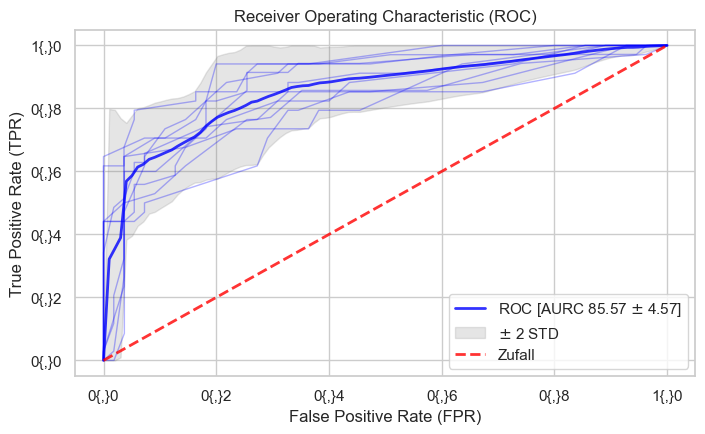

In [13]:
# Receiver Operating Characteristic (ROC) zeichnen
#  (KNIME: "ROC Curve")
dst_roc_SAVE(model, X, y, cv=skf)

##### Ergebnisse

#### Version 4: k = 9

Confusion Matrix

* TN (True  Negatives) : 502
* TP (True  Positives) : 237
* FN (False Negatives) : 105
* FP (False Positives) : 47

Gütemaße

* Genauigkeit  (Accuracy)    :   82,94 %
* Spezifität   (Specificity) :   91,43 %
* Sensitivität (Sensitivity) :   69,32 %
* Präzision    (Precision)   :   83,58 %
* Recall       (Recall)      :   69,32 %
* F-Maß        (F Score)     :   75,49 %
* AURC         (AURC)        :   86,52 %
* LogLoss      (LogLoss)     :    1,234

Mittelwert

* Mittelwert (Accuracy, F Score, AURC, Precision):  82,13 %

#### Version 5: k = 29

Confusion Matrix

* TN (True  Negatives) : 525
* TP (True  Positives) : 208
* FN (False Negatives) : 134
* FP (False Positives) : 24

Gütemaße

* Genauigkeit  (Accuracy)    :   82,27 %
* Spezifität   (Specificity) :   95,63 %
* Sensitivität (Sensitivity) :   60,82 %
* Präzision    (Precision)   :   89,80 %
* Recall       (Recall)      :   60,82 %
* F-Maß        (F Score)     :   72,07 %
* AURC         (AURC)        :   85,71 %
* LogLoss      (LogLoss)     :    0,474

Mittelwert

* Mittelwert (Accuracy, F Score, AURC, Precision):  82,46 %